## *Tomato Disease CNN*

Dataset: https://www.kaggle.com/arjuntejaswi/plant-village

In [28]:
import tensorflow as tf
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

### Constants

In [3]:
BATCH_SIZE = 32
EPOCHS = 20
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3

## Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataset",
    seed=123,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 10373 files belonging to 5 classes.


### General knowledge

In [26]:
class_names = dataset.class_names
class_names

['Bacterial_spot',
 'Healthy',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'YellowLeaf__Curl_Virus']

### Visualize some of the images from our dataset

2024-08-04 16:58:44.319506: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


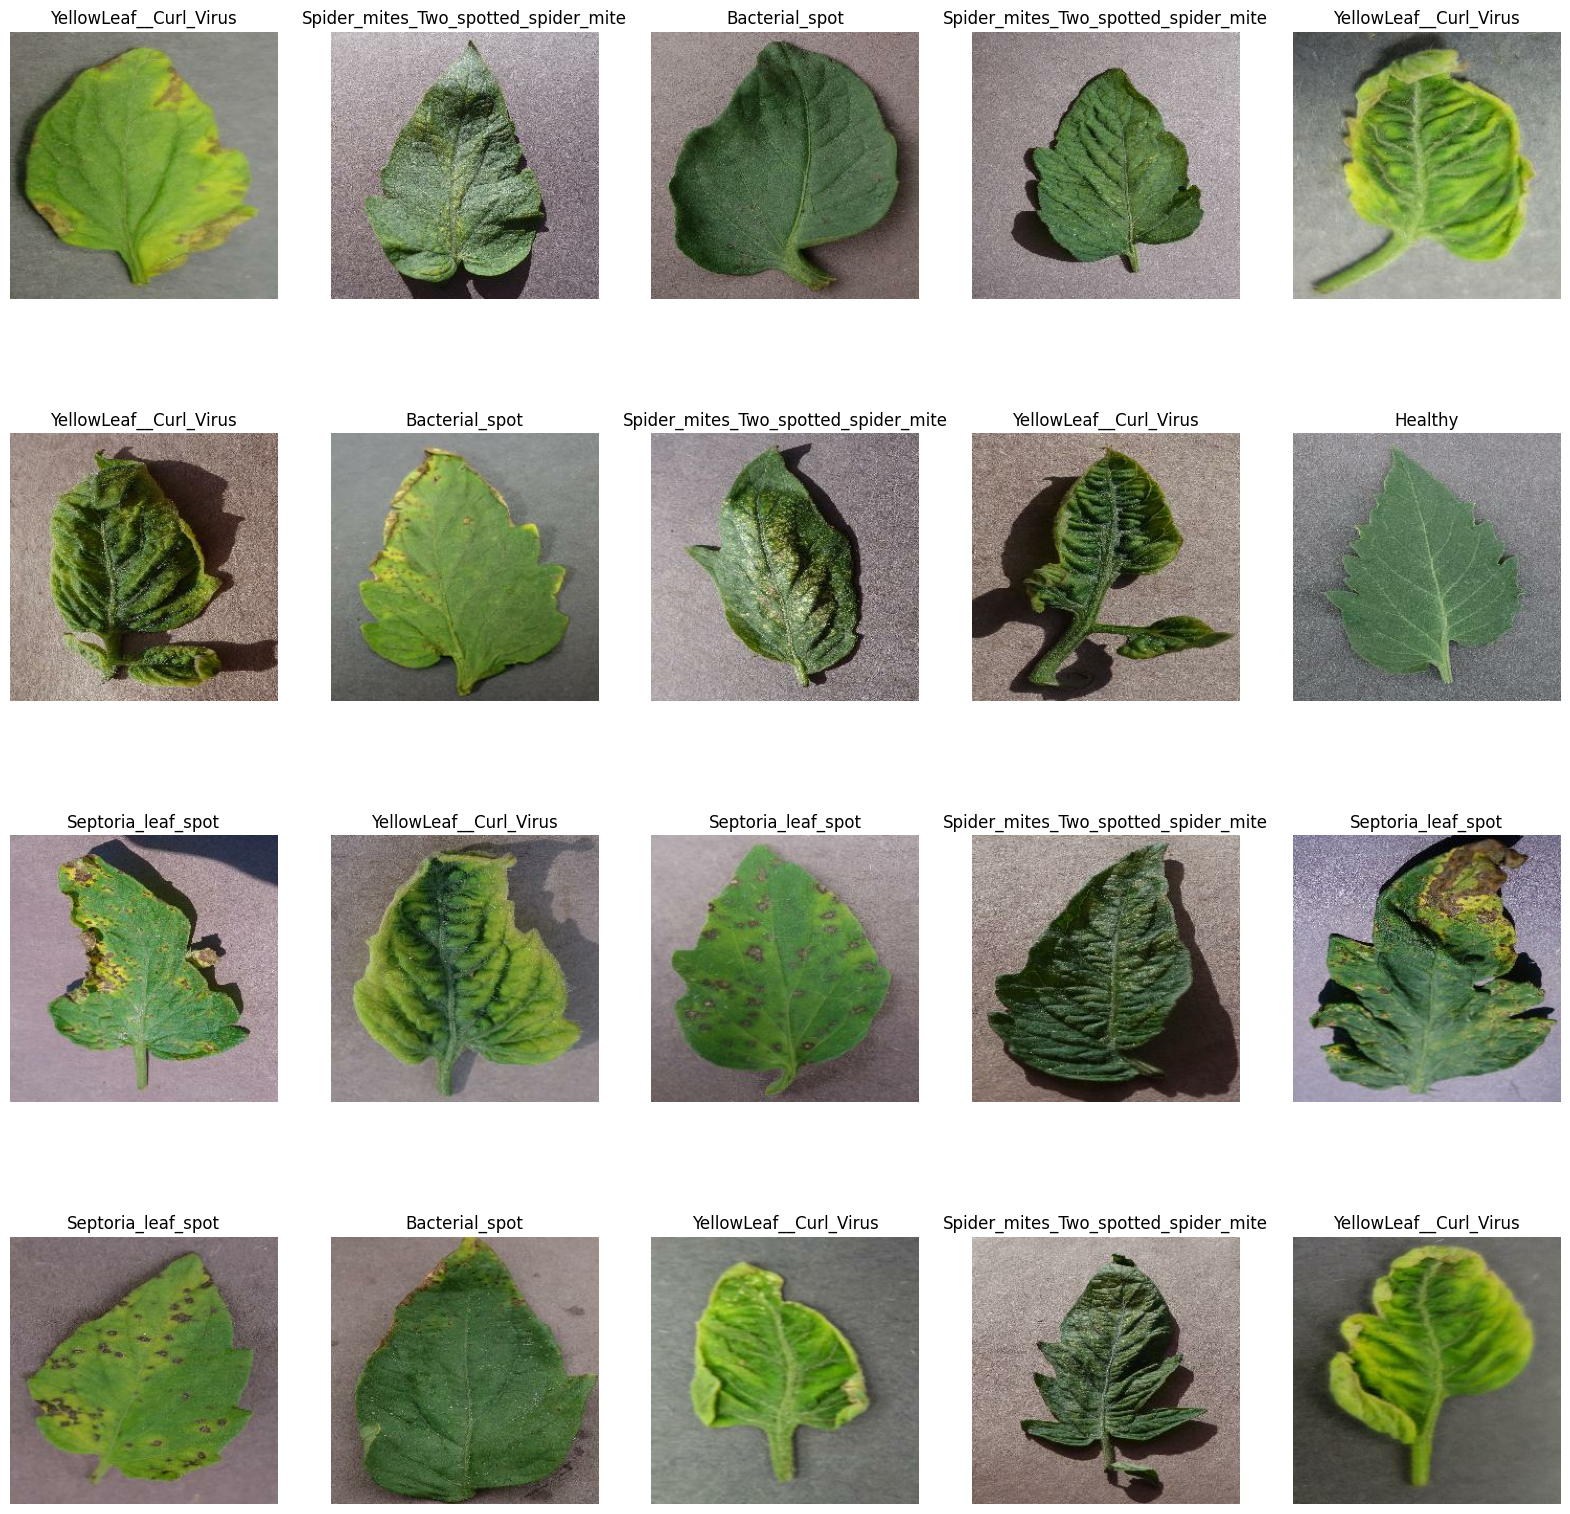

In [6]:
plt.figure(figsize=(20, 20))
for image_batch, lebels_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[lebels_batch[i]])
        plt.axis("off")

### Split data into training 80% and validation 10% and testing 10%

In [7]:
def train_test_val_split(dataset):
    dataset = dataset.shuffle(1000, seed=42)
    
    ds_size = len(dataset)
    train_size = int(ds_size * 0.8)
    test_size = int(ds_size * 0.1)
    
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).take(test_size)
    val_ds = dataset.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = train_test_val_split(dataset)

In [9]:
print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(val_ds)} batches")
print(f"Test dataset: {len(test_ds)} batches")

Training dataset: 260 batches
Validation dataset: 33 batches
Test dataset: 32 batches


## Optimize the datasets for performance

Cache, Shuffle, and Prefetch the Dataset


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

data normalization: rescale the image to ensure 256x256

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.Rescaling(1./255)
])

### Create the CNN model

In [13]:
input_shape = (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
num_classes = len(dataset.class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, 3, activation="relu", input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes,activation="softmax")
])

model.build(input_shape=input_shape)

/Users/anaskanafani/Desktop/ml/Tomato-disease-cnn/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [15]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.4185 - loss: 1.3189 - val_accuracy: 0.5536 - val_loss: 1.7492
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.7730 - loss: 0.6054 - val_accuracy: 0.7130 - val_loss: 0.9191
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8623 - loss: 0.3620 - val_accuracy: 0.9002 - val_loss: 0.2778
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8968 - loss: 0.2921 - val_accuracy: 0.8553 - val_loss: 0.4084
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.9168 - loss: 0.2316 - val_accuracy: 0.9459 - val_loss: 0.1521
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.9207 - loss: 0.2113 - val_accuracy: 0.8184 - val_loss: 0.5787
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9360 - loss: 0.1735 - val_accuracy: 0.8870 - val_loss: 0.3337
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9462 - loss: 0.1562 - val_accu

### Evaluate Dataset

In [17]:
score = model.evaluate(test_ds)

260/260 ━━━━━━━━━━━━━━━━━━━━ 77s 295ms/step - accuracy: 0.9740 - loss: 0.0732


In [21]:
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1] * 100}%")


Test loss: 0.07274306565523148
Test accuracy: 97.35921621322632%


In [18]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

### Plot the accuracy and loss

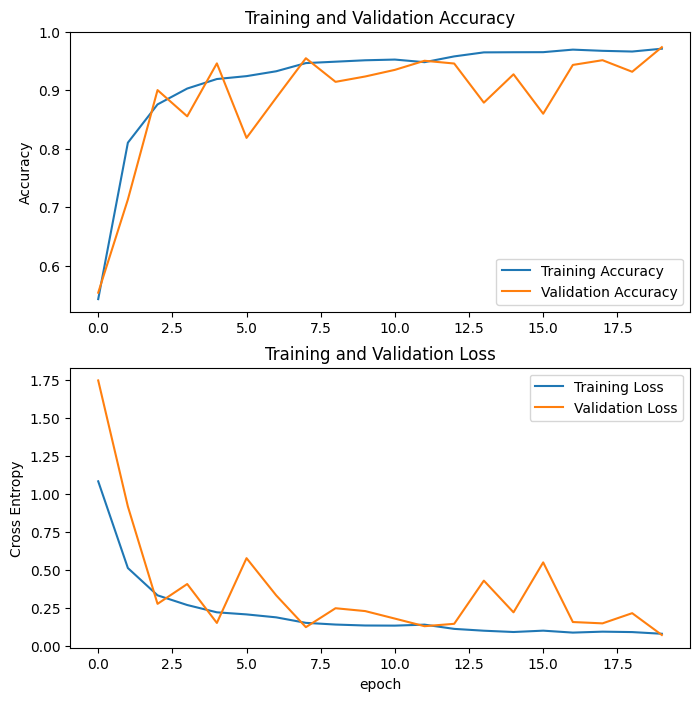

In [23]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

### Define Prediction Function

In [36]:
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

### Run prediction on a sample image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


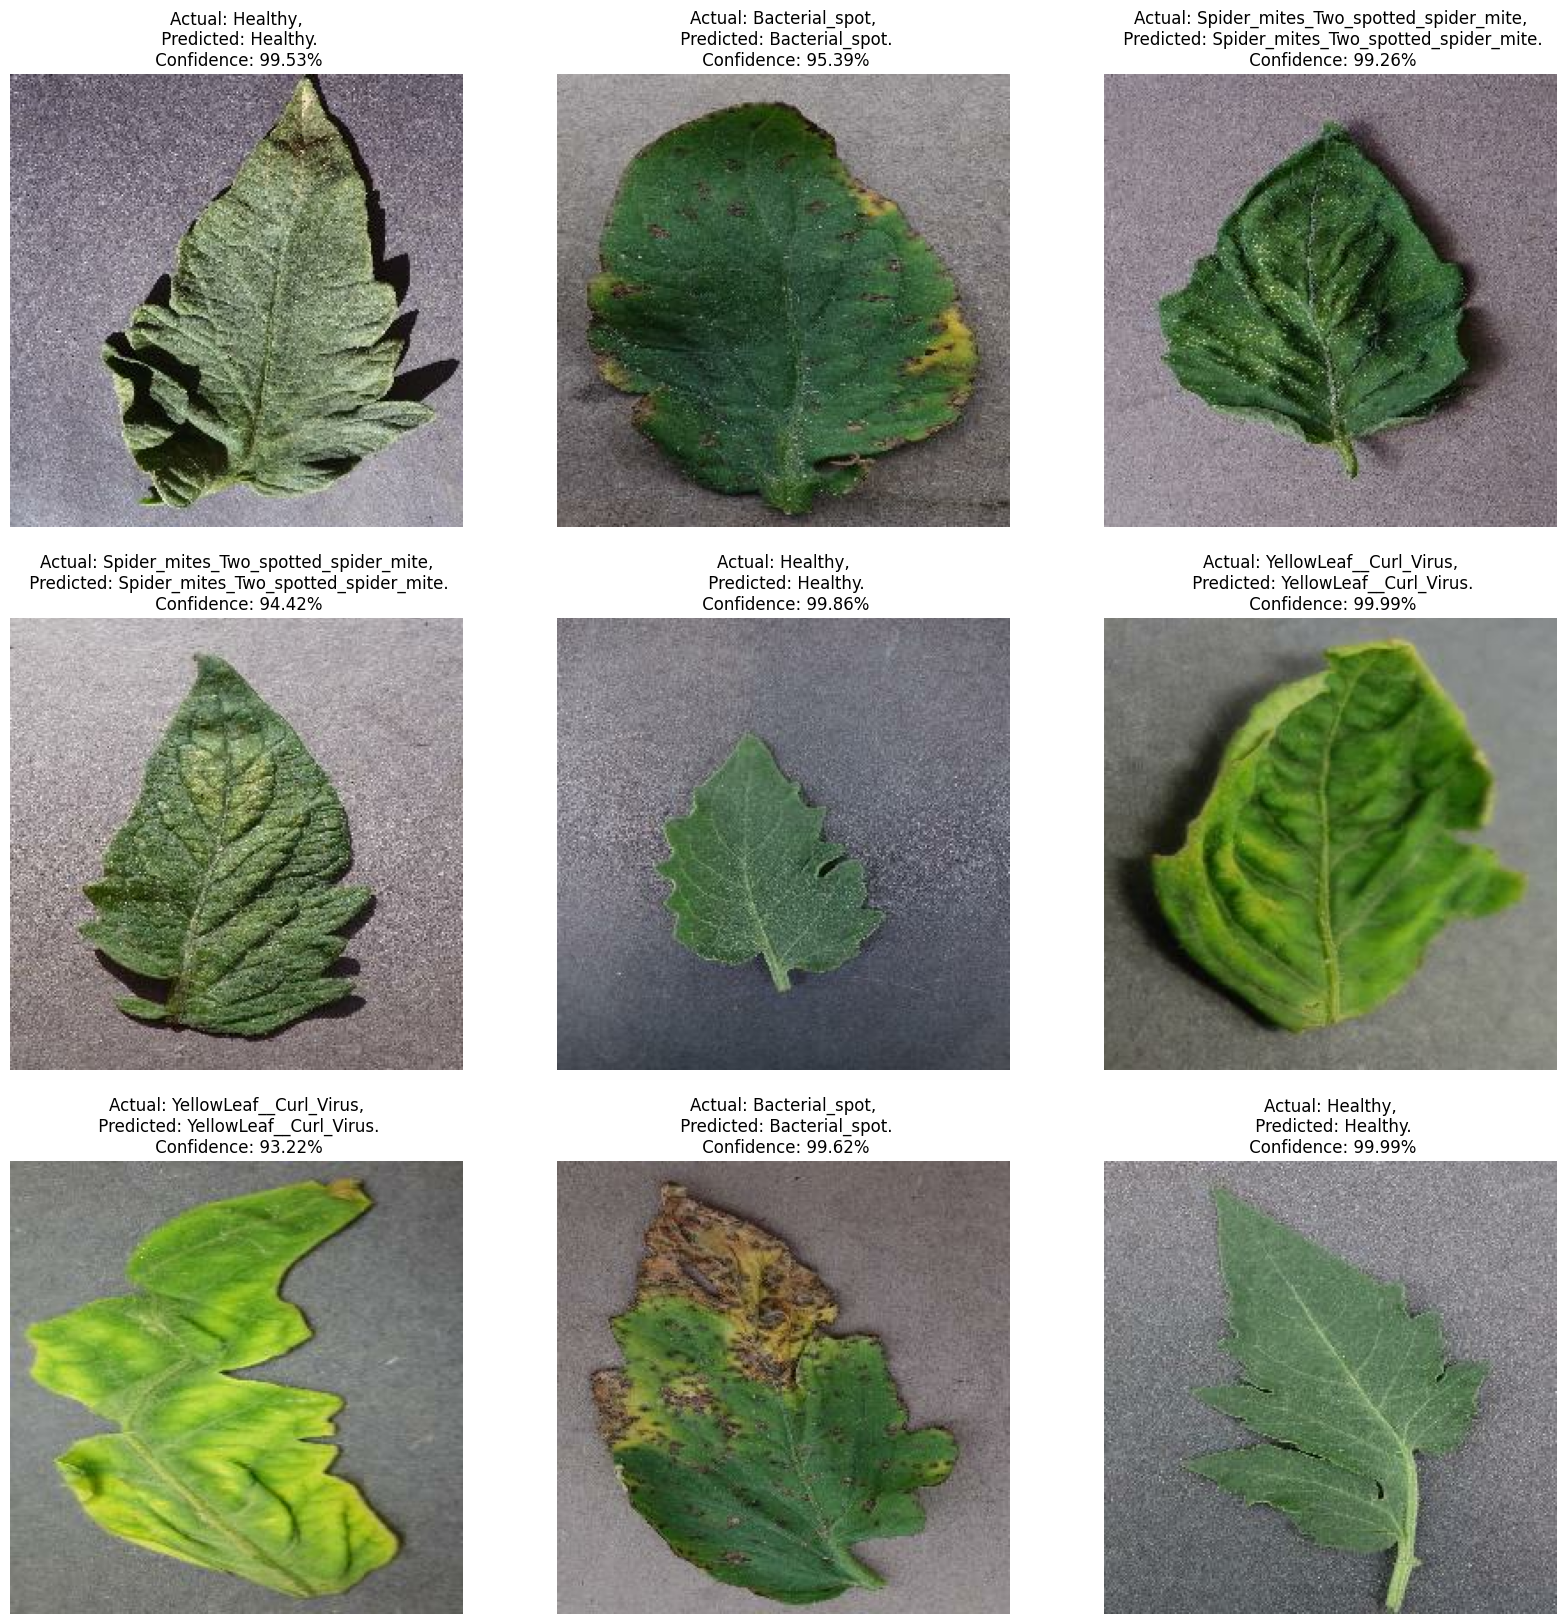

In [55]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        image = image_batch[i]
        label = labels_batch[i]
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))

        predicted_class, confidence = predict_image(model, image.numpy())
        actual_class = class_names[label]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

### Save the model

increase model version on every save to keep track of the model

In [80]:
import os
model_version = max([int(x.split("_V")[1].split(".")[0]) for x in os.listdir("../models/") if "tomato_disese_model" in x] + [0]) + 1
model.save(f"../models/tomato_disese_model_V{model_version}.keras")